In [ ]:
import numpy as np
import pandas as pd
import pickle
from PIL import Image
import torch
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.datasets as ds
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
import os
import requests
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision.models as models
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/dl2')
# Run the models on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Commonly used values for CIFAR10 normalization
mean,std = [0.4914, 0.4822, 0.4465],[0.2023, 0.1994, 0.2010]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])
# Load the data
train_dataset = ds.CIFAR10(root='./data', train=True, download=True, transform=transform)
testing_dataset = ds.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_dataset,testing_dataset


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files already downloaded and verified
Files already downloaded and verified


(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
            ))

In [ ]:
# Split a validation set from test set
test_dataset, val_dataset = random_split(testing_dataset, [5000, 5000])

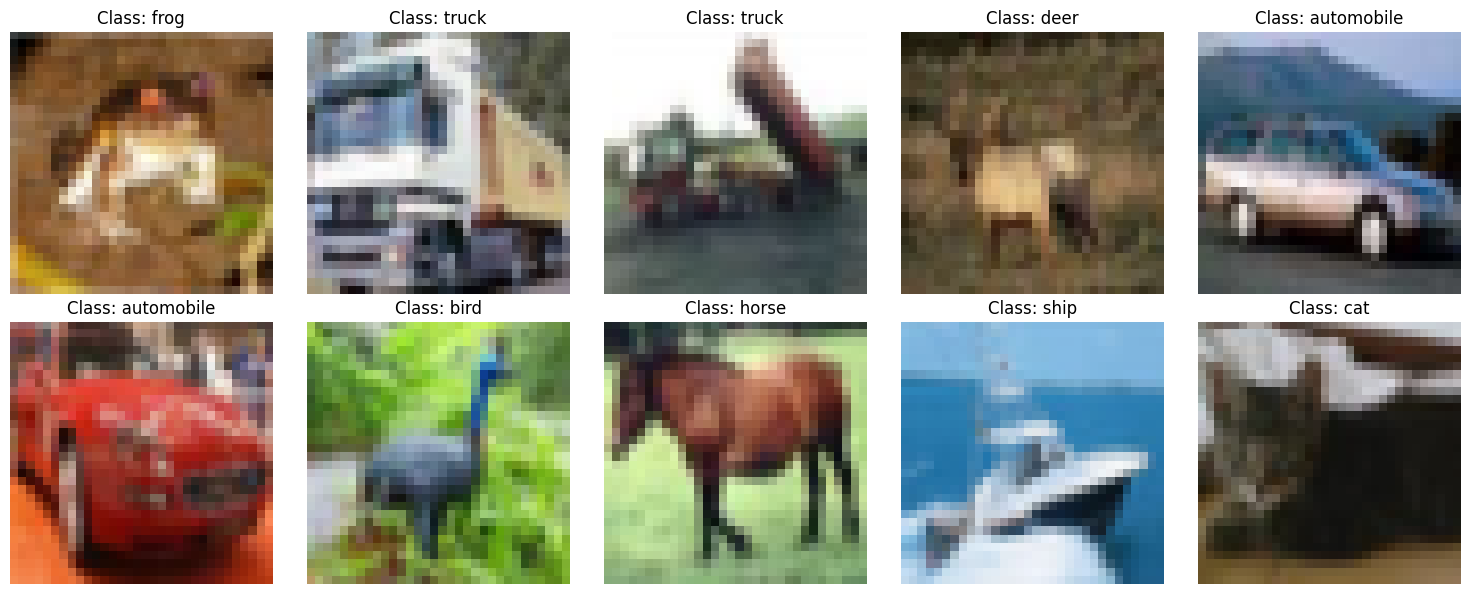

In [ ]:
# Create train, validation, and test sets for training
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=100, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

# 10 classes of CIFAR-10
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Denormalization
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Display the first 10 images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i in range(10):
    image, label = train_dataset[i]
    image = denormalize(image, mean, std)
    class_name = classes[label]
    ax = axes[i]
    ax.imshow(image.permute(1, 2, 0).clamp(0, 1))  #  ensure values are in [0, 1]
    ax.set_title(f"Class: {class_name}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=5):

    train_loss_history = []
    val_loss_history = []
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        total_loss = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_loss = total_loss / len(train_loader)
        train_loss_history.append(train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                val_loss = criterion(outputs, y)
                total_val_loss += val_loss.item()

                _, predicted = torch.max(outputs, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()

        val_accuracy = correct / total
        val_loss = total_val_loss / len(val_loader)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            epochs_no_improve = 0
            best_val_loss = val_loss
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping at Epoch {epoch+1}")
                break

    # Plot training and validation loss
    plt.plot(train_loss_history, label='Training Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.legend()
    plt.show()

    return model, train_loss_history, val_loss_history


In [ ]:
#Load a pre-trained ResNet
resnet_model2 = models.resnet34(pretrained=True)
# change the last layer to 10 classes
resnet_model2.fc = torch.nn.Linear(resnet_model2.fc.in_features,10)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Training with learning rate: 0.001
Epoch 1/50, Train Loss: 1.7701, Validation Loss: 1.3759, Validation Accuracy: 0.5242
Epoch 2/50, Train Loss: 1.2012, Validation Loss: 1.1080, Validation Accuracy: 0.6080
Epoch 3/50, Train Loss: 1.0050, Validation Loss: 0.9907, Validation Accuracy: 0.6478
Epoch 4/50, Train Loss: 0.8886, Validation Loss: 0.9169, Validation Accuracy: 0.6736
Epoch 5/50, Train Loss: 0.8108, Validation Loss: 0.8633, Validation Accuracy: 0.6966
Epoch 6/50, Train Loss: 0.7422, Validation Loss: 0.8194, Validation Accuracy: 0.7154
Epoch 7/50, Train Loss: 0.6887, Validation Loss: 0.7976, Validation Accuracy: 0.7258
Epoch 8/50, Train Loss: 0.6388, Validation Loss: 0.7729, Validation Accuracy: 0.7342
Epoch 9/50, Train Loss: 0.5988, Validation Loss: 0.7524, Validation Accuracy: 0.7380
Epoch 10/50, Train Loss: 0.5587, Validation Loss: 0.7422, Validation Accuracy: 0.7468
Epoch 11/50, Train Loss: 0.5240, Validation Loss: 0.7387, Validation Accuracy: 0.7496
Epoch 12/50, Train Loss: 0.

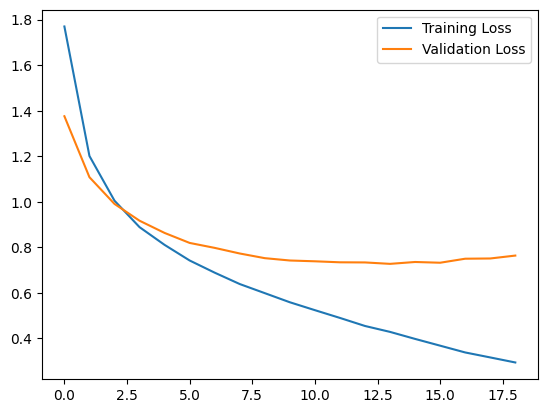

New best model saved with learning rate: 0.001 at path ResNet34.pth

Training with learning rate: 0.01
Epoch 1/50, Train Loss: 0.4297, Validation Loss: 0.7369, Validation Accuracy: 0.7618
Epoch 2/50, Train Loss: 0.2908, Validation Loss: 0.7342, Validation Accuracy: 0.7748
Epoch 3/50, Train Loss: 0.1935, Validation Loss: 0.7541, Validation Accuracy: 0.7890
Epoch 4/50, Train Loss: 0.1417, Validation Loss: 0.8107, Validation Accuracy: 0.7838
Epoch 5/50, Train Loss: 0.0976, Validation Loss: 0.8646, Validation Accuracy: 0.7954
Epoch 6/50, Train Loss: 0.0817, Validation Loss: 0.9079, Validation Accuracy: 0.7876
Epoch 7/50, Train Loss: 0.0651, Validation Loss: 0.9461, Validation Accuracy: 0.7910
Early stopping at Epoch 7


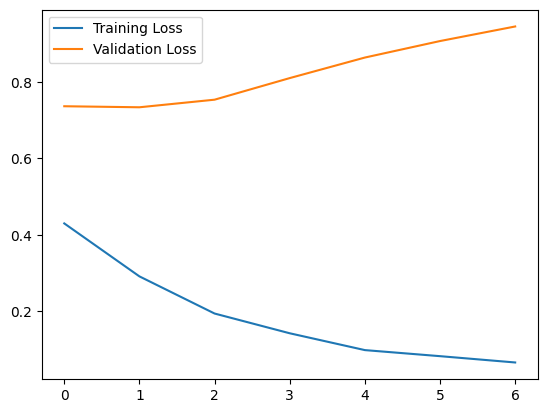


Training with learning rate: 0.1
Epoch 1/50, Train Loss: 0.9422, Validation Loss: 1.0401, Validation Accuracy: 0.6440
Epoch 2/50, Train Loss: 0.5555, Validation Loss: 0.6211, Validation Accuracy: 0.7948
Epoch 3/50, Train Loss: 0.3684, Validation Loss: 0.5889, Validation Accuracy: 0.8048
Epoch 4/50, Train Loss: 0.2666, Validation Loss: 0.5227, Validation Accuracy: 0.8326
Epoch 5/50, Train Loss: 0.1779, Validation Loss: 0.5816, Validation Accuracy: 0.8294
Epoch 6/50, Train Loss: 0.1340, Validation Loss: 0.6783, Validation Accuracy: 0.8132
Epoch 7/50, Train Loss: 0.1063, Validation Loss: 0.7551, Validation Accuracy: 0.8042
Epoch 8/50, Train Loss: 0.0917, Validation Loss: 0.6848, Validation Accuracy: 0.8274
Epoch 9/50, Train Loss: 0.0701, Validation Loss: 0.7343, Validation Accuracy: 0.8246
Early stopping at Epoch 9


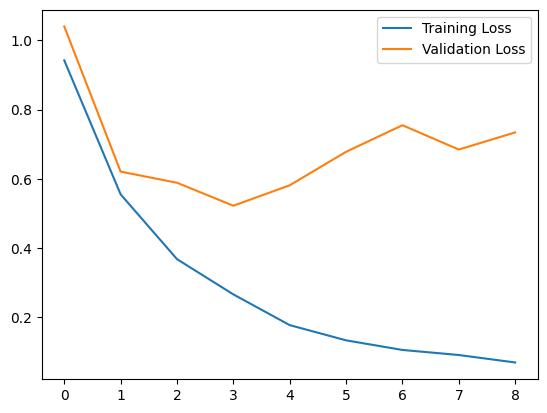

New best model saved with learning rate: 0.1 at path ResNet34.pth
Best learning rate: 0.1


In [ ]:
criterion = nn.CrossEntropyLoss()
learning_rates = [0.001,0.01, 0.1]
best_val_loss = float('inf')
best_model_path = 'ResNet34.pth'

for lr in learning_rates:

    print(f"\nTraining with learning rate: {lr}")

    model = resnet_model2.to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    _, _, val_loss_history = train_model(model, train_loader, val_loader, criterion, optimizer)

    if min(val_loss_history) < best_val_loss:

        best_val_loss = min(val_loss_history)

        best_lr = lr

        # Save this model

        torch.save(model.state_dict(), best_model_path)

        print(f"New best model saved with learning rate: {lr} at path {best_model_path}")


print(f"Best learning rate: {best_lr}")

In [ ]:
# Load and evaluate the best model on the test set

model = resnet_model2.to(device)
model.load_state_dict(torch.load(best_model_path))
model.eval()

correct = 0
total = 0

with torch.no_grad():

    for X, y in test_loader:

        X, y = X.to(device), y.to(device)

        outputs = model(X)

        _, predicted = torch.max(outputs.data, 1)

        total += y.size(0)

        correct += (predicted == y).sum().item()


print(f"Accuracy of the best model on the test dataset: {100 * correct / total:.2f}%")

Accuracy of the best model on the test dataset: 82.62%
